# CTF figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the contrast transfer function figure (Fig. 5) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
import cmasher as cmr
import matplotlib.cm as cm
from matplotlib import colors

## Numerical Simulations

The numerical ptychographic reconstructions, which are rather costly, are performed with the `ptycho-paper-figures-2024/240520_contrast-transfer-function_script.py` file in the same directory (which accepts a single command-line argument to set the strength, `phi0`, of the white-noise object).

The script produces three numpy files:
- `G_ideal_ptycho_phi0{phi0}.npy`: The input object power spectrum as a function of defocus
- `G_recon_ptycho_phi0{phi0}.npy`: The ideal ptycho reconstruction object power spectrum as a function of defocus
- `G_recon_delta_ptycho_phi0{phi0}.npy`:  The noisy ptycho reconstruction object power spectrum as a function of defocus

Here, we load the arrays for `phi0=1`.

In [5]:
path = "data/"

G_ideal_01 = np.load(path + "G_ideal_ptycho_phi01.npy")
G_recon_01 = np.load(path + "G_recon_ptycho_phi01.npy")
G_recon_delta_01 = np.load(path + "G_recon_delta_ptycho_phi01.npy")

In [15]:
n = G_ideal_01.shape[-1]

phi0 = 1.0
N_counts_sim = 1e4

error_noise_pty = G_recon_delta_01[:,:,0:n//2].mean(0)
ctf_pty = G_recon_01[:,:,0:n//2].mean(0)   # numerical

# scale noise estimate by phi0 and sqrt(N) to estimate the asymptotic error_rand_ptycho
error_rand_pty = error_noise_pty / phi0 * np.sqrt(N_counts_sim / n)
error_inv_pty = 1 / error_rand_pty
error_inv_pty[:,0] = 0.0

snr_rand_pty = np.abs(ctf_pty) * error_inv_pty

## Analytical Expressions

### DPC

In [7]:
# Simulation variables
pixel_size = 0.125  # A
q_probe = 1  # 1/A
wavelength = 0.019687  # in A, from 300 kV

# coordinates
C1 = np.arange(0,256,2)  # defocus in A
q = np.fft.fftfreq(n,d=pixel_size)
q2 = q[:,None]**2 + q[None,:]**2
q1 = np.sqrt(q2)

# plotting coordinates
inds_q = np.arange(0,128).astype('int')
defocus_norm = C1 * q_probe
q_norm = q[inds_q] / q_probe

In [10]:
# initial probe
Psi_0 = np.sqrt(
        np.clip(
        (q_probe - q1)/(q[1]-q[0]) + 0.5,
        0,
        1,
    ),
)
Psi_0 /= np.sqrt(np.sum(np.abs(Psi_0)**2))

# CTF for DPC
ctf_dpc = np.zeros((C1.size,q_norm.size))
for a0 in range(C1.size):
    Psi = Psi_0 * np.exp(-1j*np.pi*wavelength*C1[a0]*q2)
    Psi_corr = np.real(
        np.fft.ifft2(
            np.abs(
                np.fft.fft2(
                    Psi
                )
            )**2
        )
    )
    ctf_dpc[a0,inds_q] = Psi_corr[inds_q,0]
ctf_dpc[:,q_norm>2] = 0

    
# random noise
error_rand_dpc =  np.divide(
    np.sqrt(2)/np.pi,
    np.tile(q_norm[None,:],(C1.size,1)),
    where = np.tile(q_norm[None,:],(C1.size,1)) > 0.0,
)
error_rand_dpc[:,0] = 0.0
error_inv_dpc = np.divide(
    1,
    error_rand_dpc,
    where = error_rand_dpc > 0.0,
)
error_inv_dpc[:,0] = 0.0

snr_rand_dpc = np.abs(ctf_dpc) * error_inv_dpc

### Parallax

In [12]:
# parallax analytic CTF and random noise error

# autocorrelation of the aperture
aper_corr = np.real(
    np.fft.ifft2(
        np.abs(
            np.fft.fft2(
                Psi_0
            )
        )**2
    )
)

# propagator
prop = np.sin(np.pi*wavelength*C1[:,None]*q2[0,inds_q][None,:])

# CTF of parallax
ctf_par = aper_corr[inds_q,0][None,:] * prop
ctf_par[:,q_norm>2] = 0

# random noise
error_rand_par = (np.sqrt(2)/np.pi) / q_probe * np.ones(ctf_par.shape)
error_inv_par = (np.pi / np.sqrt(2)) * q_probe * np.ones(ctf_par.shape)

snr_rand_par = np.abs(ctf_par) * error_inv_par

## Visualization

In [19]:
def estimate_error(
    ctf,
    error_rand,
    q_norm,
    q_range = (0.0,2.0),
    N_counts_array = 10**np.arange(0,2+0.01,0.01),
    scale_by_sqrt_counts = True,
    use_median = False,
    sigma = 2.0,
):
    """
    Estimate the mean phase error over a given range of alpha values.
    """
    
    out_shape = (ctf.shape[0],N_counts_array.size)
    error_total_rand = np.zeros(out_shape)
    
    # subset of alpha / q values to estimate error over
    sub = np.logical_and(
        q_norm >= q_range[0],
        q_norm <= q_range[1],
    )

    # ctf denominator
    
    # systematic error
    error_syst = 1 - np.abs(ctf)
    if use_median:
        error_syst_sub = np.median(error_syst[:,sub],axis=1)
        num_sub = np.median(np.abs(ctf)[:,sub],axis=1)
    else:
        error_syst_sub = np.mean(error_syst[:,sub],axis=1)
        num_sub = np.mean(np.abs(ctf)[:,sub],axis=1)
    error_total_syst = np.tile(
        error_syst_sub[:,None],
        (1,out_shape[1]),
    )

    error_total_num = np.tile(
        num_sub[:,None],
        (1,out_shape[1]),
    )
    
    # random error due to noise
    for a0 in range(N_counts_array.size):
        N_counts = N_counts_array[a0]
        error_noise = error_rand / N_counts
            
        if use_median:
            error_noise_sub = np.median(error_noise[:,sub],axis=1)
        else:
            error_noise_sub = np.mean(error_noise[:,sub],axis=1)
                
        error_total_rand[:,a0] = error_noise_sub
    
    if scale_by_sqrt_counts:
        error_total_rand *= np.sqrt(N_counts_array[None,:])
        error_total_syst *= np.sqrt(N_counts_array[None,:])
    
    # smoothing to reduce noise at edges
    if sigma > 0.0:
        error_total_rand = gaussian_filter(
            error_total_rand,
            sigma = sigma,
            mode = 'nearest',
        )
        error_total_syst = gaussian_filter(
            error_total_syst,
            sigma = sigma,
            mode = 'nearest',
        )
    
    # combined errors
    error_total = np.sqrt(error_total_syst**2 + error_total_rand**2)
    
    # # normalization by CTF
    sig_total = error_total_num
    sub_sig = sig_total > 1e-8
    error_total[sub_sig] /= sig_total[sub_sig]
    error_total[np.logical_not(sub_sig)] = np.inf
    
    return error_total

In [20]:
N_counts_array = 10**np.linspace(0,2,256)

error_total_dpc_two_alpha = estimate_error(
    ctf_dpc,
    error_rand_dpc,
    q_norm,
    q_range = [0,2],
    N_counts_array = N_counts_array,
)
error_total_par_two_alpha = estimate_error(
    ctf_par,
    error_rand_par,
    q_norm,
    q_range = [0,2],
    N_counts_array = N_counts_array,
)
error_total_pty_two_alpha = estimate_error(
    ctf_pty,
    error_rand_pty,
    q_norm,
    q_range = [0,2],
    N_counts_array = N_counts_array,
)

error_total_dpc_alpha = estimate_error(
    ctf_dpc,
    error_rand_dpc,
    q_norm,
    q_range = [0,1],
    N_counts_array = N_counts_array,
)
error_total_par_alpha = estimate_error(
    ctf_par,
    error_rand_par,
    q_norm,
    q_range = [0,1],
    N_counts_array = N_counts_array,
)
error_total_pty_alpha = estimate_error(
    ctf_pty,
    error_rand_pty,
    q_norm,
    q_range = [0,1],
    N_counts_array = N_counts_array,
)

### Schematics

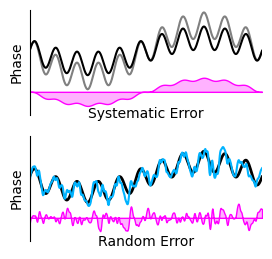

In [29]:
# example - systematic
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(3,3))

t = np.linspace(0,2*np.pi,501)
sig = -np.sin(t * 1.0) + np.sin(t*11.0)*0.5
sig_meas = -np.sin(t * 1.0)*0.5 + np.sin(t*11.0)*0.45

ax1.plot(
    t,
    sig+1.6,
    linewidth = 1.5,
    c = (0.5,0.5,0.5),
)
ax1.plot(
    t,
    sig_meas+1.6,
    linewidth = 1.5,
    c = (0,0,0),
)
ax1.fill_between(
    t,
    sig - sig_meas,
    linewidth = 1,
    edgecolor = (1,0,1,1),
    facecolor = (1,0,1,0.3),
)
ax1.set_xlim((0,2*np.pi))
ax1.set_ylim((-0.9,3.2))
ax1.set_xticks(())
ax1.set_yticks(())
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylabel('Phase')
ax1.text(
    np.pi,-1.0,
    'Systematic Error',
    horizontalalignment = 'center',
)

# example - random
t = np.linspace(0,2*np.pi,501)
sig_meas = -np.sin(t * 1.0)*0.6 + np.sin(t*11.0)*0.4
sig_noise = np.random.randn(t.size)
sig_noise = gaussian_filter(sig_noise,sigma=2.0,mode='nearest') * 0.5
ax2.plot(
    t,
    sig_meas + 1.6,
    linewidth = 2,
    c = (0,0,0),
)
ax2.plot(
    t,
    sig_meas + sig_noise + 1.6,
    linewidth = 1.5,
    c = (0,0.7,1),
)

ax2.fill_between(
    t,
    sig_noise,
    linewidth = 1,
    edgecolor = (1,0,1,1),
    facecolor = (1,0,1,0.3),
)
ax2.set_xlim((0,2*np.pi))
ax2.set_ylim((-0.9,3.2))
ax2.set_xticks(())
ax2.set_yticks(())
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_ylabel('Phase')
ax2.text(
    np.pi,-1.1,
    'Random Error',
    horizontalalignment = 'center',
);


### Phase Diagrams

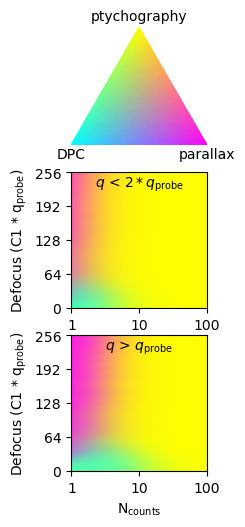

In [23]:
# from colorspacious import cspace_convert
from matplotlib.collections import PolyCollection
from scipy.spatial import Delaunay

def barycentric_coords(a,b,c):
    x = 0.5 * ( 2.*b+c ) / ( a+b+c )
    y = 0.5*np.sqrt(3) * c / (a+b+c)
    return x,y

### EMDEDDING
power = -2
error_total_sum_two_alpha = (error_total_dpc_two_alpha)**power + (error_total_par_two_alpha)**power + (error_total_pty_two_alpha)**power
error_total_dpc_norm_two_alpha = (error_total_dpc_two_alpha)**power  / error_total_sum_two_alpha
error_total_par_norm_two_alpha = (error_total_par_two_alpha)**power / error_total_sum_two_alpha
error_total_pty_norm_two_alpha = (error_total_pty_two_alpha)**power  / error_total_sum_two_alpha

ternary_diagram_xyz_two_alpha = np.zeros(error_total_dpc_norm_two_alpha.shape+(3,))
ternary_diagram_xyz_two_alpha[:,:,0] = error_total_dpc_norm_two_alpha
ternary_diagram_xyz_two_alpha[:,:,1] = error_total_par_norm_two_alpha
ternary_diagram_xyz_two_alpha[:,:,2] = error_total_pty_norm_two_alpha

# ternary_diagram_two_alpha = cspace_convert(ternary_diagram_xyz_two_alpha,"XYZ1","sRGB1").clip(0,1)
ternary_diagram_two_alpha = 1-ternary_diagram_xyz_two_alpha

error_total_sum_alpha = (error_total_dpc_alpha)**power + (error_total_par_alpha)**power + (error_total_pty_alpha)**power
error_total_dpc_norm_alpha = (error_total_dpc_alpha)**power / error_total_sum_alpha
error_total_par_norm_alpha = (error_total_par_alpha)**power / error_total_sum_alpha
error_total_pty_norm_alpha = (error_total_pty_alpha)**power / error_total_sum_alpha

ternary_diagram_xyz_alpha = np.zeros(error_total_sum_alpha.shape+(3,))
ternary_diagram_xyz_alpha[:,:,0] = error_total_dpc_norm_alpha
ternary_diagram_xyz_alpha[:,:,1] = error_total_par_norm_alpha
ternary_diagram_xyz_alpha[:,:,2] = error_total_pty_norm_alpha

# ternary_diagram_alpha = cspace_convert(ternary_diagram_xyz_alpha,"XYZ1","sRGB1").clip(0,1)
ternary_diagram_alpha = 1-ternary_diagram_xyz_alpha

a,b,c = np.mgrid[0:1:64j,0:1:64j,0:1:64j]
indices = np.isclose((a.ravel() + b.ravel() + c.ravel()),1)
a = a.ravel()[indices]
b = b.ravel()[indices]
c = c.ravel()[indices]

x,y = barycentric_coords(a,b,c)

tri = Delaunay(np.stack([x,y],axis=-1))
vertices = np.stack((
    tri.points[tri.simplices, 0], # x
    tri.points[tri.simplices, 1], # y
), axis=-1)

XYZ = np.zeros(tri.simplices.shape)
XYZ[:,0] = a[tri.simplices].mean(1)
XYZ[:,1] = b[tri.simplices].mean(1)
XYZ[:,2] = c[tri.simplices].mean(1)

# cols = cspace_convert(XYZ,"XYZ1","sRGB1").clip(0,1)
cols = 1 - XYZ

collection = PolyCollection(vertices,edgecolor='face')
collection.set_facecolor(cols)

x_pt_reg, y_pt_reg = barycentric_coords(*(ternary_diagram_xyz_two_alpha[::4,::8].reshape((-1,3)).T))
x_pt_sup, y_pt_sup = barycentric_coords(*(ternary_diagram_xyz_alpha[::4,::8].reshape((-1,3)).T))

fig, axs = plt.subplots(3,1,figsize=(2.5,6))

axs[0].add_collection(collection)
#axs[0].scatter(x_pt_reg,y_pt_reg,marker="x",color='k',s=5)
#axs[0].scatter(x_pt_sup,y_pt_sup,marker="+",color='w',s=5)

axs[0].text(1/2,np.sqrt(3)/2 + 0.05,'ptychography',horizontalalignment='center',)
axs[0].text(0,-0.1,'DPC',horizontalalignment='center',)
axs[0].text(1,-0.1,'parallax',horizontalalignment='center',)
axs[0].set_aspect("equal")
axs[0].axis('off')

for ax, arr in zip(axs[1:],[ternary_diagram_two_alpha,ternary_diagram_alpha]):
    ax.imshow(arr)
    ax.set_xticks((0,128,256),labels=('1','10','100'))
    ax.set_xlabel(r"N$_{\mathrm{counts}}$")
    ax.set_aspect(2)
    
    ax.set_yticks(np.arange(0,128+32,32),labels=np.arange(0,256+64,64))
    ax.set_ylabel(r"Defocus (C1 * q$_\mathrm{probe}$)")
    ax.invert_yaxis()

axs[1].text(128,114,r"$q$ < $2*q_{\mathrm{probe}}$",horizontalalignment='center')
axs[2].text(128,114,r"$q$ > $q_{\mathrm{probe}}$",horizontalalignment='center');

### Main Panels

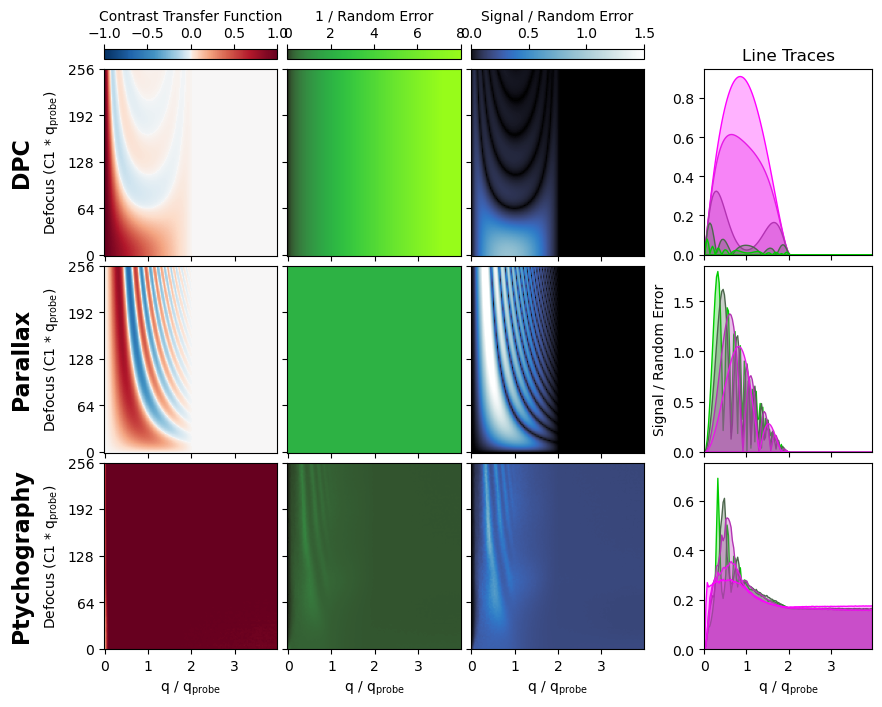

In [30]:
fig = plt.figure(figsize=(12,6))

grid_rand = ImageGrid(
    fig,
    (0,0,0.45,1.0),
    nrows_ncols=(3,3),
    axes_pad=0.1,
    cbar_pad=0.1,
    cbar_mode="edge",
    cbar_location="top",
    share_all=True,
    aspect = False,
)

grid_rand_lines = [
    fig.add_axes([0.5,0.658,0.14,0.31]),
    fig.add_axes([0.5,0.329,0.14,0.31]),
    fig.add_axes([0.5,0.000,0.14,0.31]),
]

# main plot panels
vmins = [-1,0,0]*3
vmaxs = [1,8,1.5]*3

arrs = [
    ctf_dpc, error_inv_dpc, snr_rand_dpc,
    ctf_par, error_inv_par, snr_rand_par,
    ctf_pty, error_inv_pty, snr_rand_pty,
]
cbar_labels = [
    r"Contrast Transfer Function",
    r"1 / Random Error",
    "Signal / Random Error",
]*3


t = np.linspace(0,1,1024+1)
t1 = ((np.sign(t-0.5) * np.abs(2*t-1)**0.6) + 1)/2
cmap_ctf = colors.ListedColormap(plt.cm.RdBu_r(t1))

t = np.linspace(0,1,1024+1)
t1 = t**0.25
cmap_inv_error = colors.ListedColormap(cmr.nuclear(t1))

t = np.linspace(0,1,1024+1)
t1 = t**0.5
cmap_snr = colors.ListedColormap(cmr.arctic(t1))

cmaps = [
    cmap_ctf,
    cmap_inv_error,
    cmap_snr,
]*3


for ax, arr, vmin, vmax, cmap, cbar_label in zip(grid_rand,arrs,vmins,vmaxs,cmaps,cbar_labels):
    # arr
    im = ax.imshow(
        arr,
        vmin = vmin,
        vmax = vmax,
        cmap = cmap,
        aspect = 'auto',
    )

    # cbar
    ax.cax.colorbar(im)
    # ax.set_aspect(1/2)
    ax.cax.xaxis.set_ticks_position('top')
    ax.cax.set_xlabel(cbar_label)
    ax.cax.xaxis.set_label_position('top') 
    # ax.cax.set_xticks(np.array((0,2,4,6)))

    # y-axis
    ax.set_yticks(np.arange(0,128+32,32),labels=np.arange(0,256+64,64))
    ax.set_ylabel(r"Defocus (C1 * q$_\mathrm{probe}$)")
    ax.invert_yaxis()

    # x-axis
    ax.set_xticks(np.arange(0,128,32),labels=np.arange(4))
    ax.set_xlabel(r"q / q$_\mathrm{probe}$")

# large labels
grid_rand[0].text(
    -70,
    64,
    'DPC',
    verticalalignment='center',
    fontsize = 16,
    fontweight = 'bold',
    rotation = 90,
);
grid_rand[3].text(
    -70,
    64,
    'Parallax',
    verticalalignment='center',
    fontsize = 16,
    fontweight = 'bold',
    rotation = 90,
);
grid_rand[6].text(
    -70,
    64,
    'Ptychography',
    verticalalignment='center',
    fontsize = 16,
    fontweight = 'bold',
    rotation = 90,
);
    
    
# line traces
inds_line = np.array([0,15,31,63,127]).astype('int')
colors_line = [
    [1.0,0.0,1.0],
    [0.9,0.1,0.9],
    [0.7,0.2,0.7],
    [0.3,0.4,0.3],
    [0.0,0.8,0.0],
]
alpha_face = 0.3

inds = np.arange(3).astype('int')
y_lims = ((0,0.95),(0,1.85),(0,0.75))
x_lim = (q_norm[0],q_norm[-1])

for ax, ind, y_lim in zip(grid_rand_lines, inds, y_lims):
    if ind == 0:
        arr = arrs[2]
        for a0 in range(inds_line.size):
            ax.fill_between(
                q_norm,
                arr[inds_line[a0],:],#**power_plot,# / np.sqrt(N[a0]),
                edgecolor = colors_line[a0],
                facecolor = np.hstack((colors_line[a0],alpha_face)),
            )
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_xticks(np.arange(4),labels=())
    elif ind == 1:
        arr = arrs[5]
        for a0 in range(inds_line.size)[::-1]:
            ax.fill_between(
                q_norm,
                arr[inds_line[a0],:],#**power_plot,# / np.sqrt(N[a0]),
                edgecolor = colors_line[a0],
                facecolor = np.hstack((colors_line[a0],alpha_face)),
            )  
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_xticks(np.arange(4),labels=())
        ax.set_ylabel(r"Signal / Random Error")
    elif ind == 2:
        arr = arrs[8]
        for a0 in range(inds_line.size)[::-1]:
            ax.fill_between(
                q_norm,
                arr[inds_line[a0],:],#**power_plot,# / np.sqrt(N[a0]),
                edgecolor = colors_line[a0],
                facecolor = np.hstack((colors_line[a0],alpha_face)),
            )
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_xlabel(r"q / q$_\mathrm{probe}$")
        
grid_rand_lines[0].set_title(r"Line Traces");

## Postprocessing
> Done in Inkscape